## 라이브러리 버전 확인

In [227]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인

In [228]:
# 데이터 로드

import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)
train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [229]:
# 데이터 로드 구성

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords += [",", ".", "'", "\"", "%", "^", "*", "(", ")"]
num_words = 5_000

def load_data(train_data, test_data, num_words):
    
    # 데이터 중복 제거
    train_data.drop_duplicates(subset="document", inplace=True)
    test_data.drop_duplicates(subset="document", inplace=True)
    
    # 결측치 제거
    train_data.dropna(axis="rows", inplace=True)
    test_data.dropna(axis="rows", inplace=True)
    
    # 토큰화
    train_sencences = train_data["document"].apply(tokenizer.morphs)
    test_sencences = test_data["document"].apply(tokenizer.morphs)
    
    # 불용어 제거
    remove_stopwords = lambda sentence: [word for word in sentence if word not in stopwords]
    train_sentences = train_sencences.apply(remove_stopwords)
    train_sentences = list(map(list, train_sentences))
    test_sentences = test_sencences.apply(remove_stopwords).values
    test_sentences = list(map(list, test_sentences))

    total_sentence = train_sentences + test_sentences

    # word to index
    word_dict = {}
    for sentence in total_sentence:
        for word in sentence:
            if word_dict.get(word) is not None:
                word_dict[word] += 1
            else:
                word_dict[word] = 1
    word_list = sorted(word_dict.items(), key=lambda item: item[1])
    word_list = word_list[len(word_list)-num_words:]
    word_to_index = {word:index+1 for index, (word, _) in enumerate(word_list)}
    
    # 특수한 토큰 처리
    for word in word_to_index.keys(): 
        word_to_index[word] += 3
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3
    
    # vectorize
    def to_vectors(sentence):
        vector = [word_to_index['<BOS>']]
        for word in sentence:
            index = word_to_index.get(word)
            if index is not None:
                vector.append(index)
            else:
                vector.append(word_to_index["<UNK>"])
        return vector
    
    X_train = train_sencences.apply(to_vectors)
    y_train = train_data["label"]
    X_test = test_sencences.apply(to_vectors)
    y_test = test_data["label"]

    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=num_words)

In [230]:
index_to_word = { index:word for word, index in word_to_index.items() }

In [231]:
print(" ".join([index_to_word[index] for index in X_train[0]]))
print(" ".join([index_to_word[index] for index in X_train[1]]))

<BOS> 아 더 빙 <UNK> <UNK> 진짜 짜증 나 네요 목소리
<BOS> 흠 <UNK> .. 포스터 보고 초딩 영화 줄 <UNK> ... 오버 연기 조차 가볍 지 않 구나


In [232]:
# split validation
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(len(X_train), len(y_train), len(X_valid), len(y_test))


116945 116945 29237 49157


## 3) 모델 구성을 위한 데이터 분석 및 가공

In [233]:
import numpy as np
len_X_train = np.array([len(sentence) for sentence in X_train])
mean = len_X_train.mean()
max = len_X_train.max()
std = len_X_train.std()
print("train size", len(len_X_train))
print("mean", mean)
print("max", max)
print("std", std)

train size 116945
mean 19.750395485057076
max 117
std 15.329924204599436


In [234]:
max_len = round(mean + 2 * std)
print("max_len", max_len)

max_len 50


In [235]:
import tensorflow as tf

def pad_sequences(sequences, padding, max_len):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences=sequences,
                                                          value=word_to_index["<PAD>"],
                                                          padding="post",
                                                          maxlen=max_len)

X_train_post = pad_sequences(X_train, "post", max_len)
X_valid_post = pad_sequences(X_valid, "post", max_len)
X_test_post = pad_sequences(X_test, "post", max_len)
print(X_train_post.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test_post.shape, y_test.shape)

(116945, 50) (116945,) (29237,) (29237,) (49157, 50) (49157,)


In [236]:
print(X_test_post[5000])

[   1 4851    2 5002    2 4803 4855 4992    2 1012 4982 4956 4792    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## 4) 모델 구성 및 validation set 구성

In [250]:
from tensorflow.keras import layers

class Conv1DModel(tf.keras.Model):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True)
        self.conv_1 = layers.Conv1D(8, 16, activation="relu")
        self.dropout_1 = layers.Dropout(0.5)
        self.pool_1 = layers.MaxPooling1D(5)
        self.conv_2 = layers.Conv1D(16, 2, activation="relu")
        self.dropout_2 = layers.Dropout(0.5)
        self.pool_2 = layers.GlobalMaxPooling1D()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(16, activation="relu")
        self.out = layers.Dense(1, activation="sigmoid")
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.conv_1(x)
        x = self.dropout_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.dropout_2(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.fc(x)
        out = self.out(x)
        return out
    
class LSTMModel(tf.keras.Model):
    
    def __init__(self, output_size, input_dim, output_dim):
        super().__init__()
        self.embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True)
        self.bi_lstm1 = layers.Bidirectional(
                            layers.LSTM(units=output_size, 
                                        dropout=0.5, 
                                        recurrent_dropout=0.3)
                        )
        self.fc = layers.Dense(16, activation="relu")
        self.out = layers.Dense(1, activation="sigmoid")
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.bi_lstm1(x)
        x = self.fc(x)
        out = self.out(x)
        return out
        

In [240]:
conv_model = Conv1DModel(input_dim=num_words, output_dim=16)
inputs = layers.Input(shape=(49,))
conv_model(inputs)
conv_model.summary()

Model: "conv1d_model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     multiple                  80000     
_________________________________________________________________
conv1d_112 (Conv1D)          multiple                  2056      
_________________________________________________________________
dropout_31 (Dropout)         multiple                  0         
_________________________________________________________________
max_pooling1d_59 (MaxPooling multiple                  0         
_________________________________________________________________
conv1d_113 (Conv1D)          multiple                  272       
_________________________________________________________________
dropout_32 (Dropout)         multiple                  0         
_________________________________________________________________
global_max_pooling1d_49 (Glo multiple              

## 5) 모델 훈련

In [241]:
conv_model.compile(loss="binary_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])
conv_history = conv1d_model.fit(X_train_post, y_train,
                 epochs=20,
                 batch_size=256,
                 validation_data=(X_valid_post, y_valid),
                 verbose=2)

Epoch 1/20
457/457 - 3s - loss: 0.2749 - accuracy: 0.8868 - val_loss: 0.3676 - val_accuracy: 0.8382
Epoch 2/20
457/457 - 3s - loss: 0.2713 - accuracy: 0.8889 - val_loss: 0.3696 - val_accuracy: 0.8379
Epoch 3/20
457/457 - 3s - loss: 0.2706 - accuracy: 0.8894 - val_loss: 0.3703 - val_accuracy: 0.8375
Epoch 4/20
457/457 - 3s - loss: 0.2708 - accuracy: 0.8895 - val_loss: 0.3698 - val_accuracy: 0.8375
Epoch 5/20
457/457 - 3s - loss: 0.2690 - accuracy: 0.8897 - val_loss: 0.3717 - val_accuracy: 0.8375
Epoch 6/20
457/457 - 3s - loss: 0.2689 - accuracy: 0.8900 - val_loss: 0.3735 - val_accuracy: 0.8357
Epoch 7/20
457/457 - 3s - loss: 0.2673 - accuracy: 0.8906 - val_loss: 0.3741 - val_accuracy: 0.8362
Epoch 8/20
457/457 - 3s - loss: 0.2672 - accuracy: 0.8904 - val_loss: 0.3731 - val_accuracy: 0.8348
Epoch 9/20
457/457 - 2s - loss: 0.2667 - accuracy: 0.8907 - val_loss: 0.3762 - val_accuracy: 0.8341
Epoch 10/20
457/457 - 2s - loss: 0.2657 - accuracy: 0.8920 - val_loss: 0.3732 - val_accuracy: 0.8381

In [242]:
conv_results = conv1d_model.evaluate(X_test_post, y_test, 
                                     batch_size=512, 
                                     verbose=2)
print(results)

97/97 - 0s - loss: 0.3753 - accuracy: 0.8358
[0.3701452314853668, 0.8425859808921814]


In [251]:
lstm_model = LSTMModel(output_size=32, input_dim=num_words, output_dim=16)

lstm_model(inputs)
lstm_model.summary()

Model: "lstm_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     multiple                  80000     
_________________________________________________________________
bidirectional_6 (Bidirection multiple                  12544     
_________________________________________________________________
dense_100 (Dense)            multiple                  1040      
_________________________________________________________________
dense_101 (Dense)            multiple                  17        
Total params: 93,601
Trainable params: 93,601
Non-trainable params: 0
_________________________________________________________________


In [252]:
lstm_model.compile(loss="binary_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])
lstm_history = lstm_model.fit(X_train_post, y_train, 
               batch_size=256, 
               epochs=5,
               validation_data=(X_valid_post, y_valid))

Epoch 1/5
457/457 [==============================] - 217s 448ms/step - loss: 0.4342 - accuracy: 0.7981 - val_loss: 0.3586 - val_accuracy: 0.8419
Epoch 2/5
457/457 [==============================] - 205s 448ms/step - loss: 0.3539 - accuracy: 0.8451 - val_loss: 0.3564 - val_accuracy: 0.8438
Epoch 3/5
457/457 [==============================] - 205s 449ms/step - loss: 0.3431 - accuracy: 0.8527 - val_loss: 0.3536 - val_accuracy: 0.8450
Epoch 4/5
457/457 [==============================] - 205s 448ms/step - loss: 0.3385 - accuracy: 0.8536 - val_loss: 0.3521 - val_accuracy: 0.8444
Epoch 5/5
457/457 [==============================] - 205s 449ms/step - loss: 0.3346 - accuracy: 0.8565 - val_loss: 0.3507 - val_accuracy: 0.8459


In [255]:
lstm_results = lstm_model.evaluate(X_test_post, y_test, verbose=2)
print(lstm_results)

1537/1537 - 48s - loss: 0.3539 - accuracy: 0.8454
[0.3538607656955719, 0.8453729748725891]


## 6) Loss, Accuracy 그래프 시각화

In [264]:
import matplotlib.pyplot as plt

%matplotlib inline

def visulization(model_name, history):
    
    history_dict = history.history
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
    accuracy = history_dict["accuracy"]
    val_accuracy = history_dict["val_accuracy"]
    
    plt.figure(figsize=(10, 6))
    
    plt.title(model_name)
    
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(range(1, len(loss)+1), loss, color="blue", label="train")
    plt.plot(range(1, len(val_loss)+1), val_loss, color="orange", label="valid")
    plt.legend()
    
    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(range(1, len(accuracy)+1), accuracy, color="blue", label="train")
    plt.plot(range(1, len(val_accuracy)+1), val_accuracy, color="orange", label="valid")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

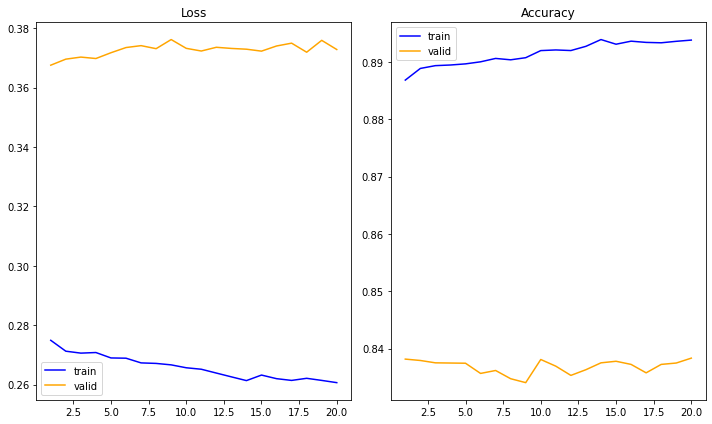

In [265]:
visulization("Conv1D", conv_history)

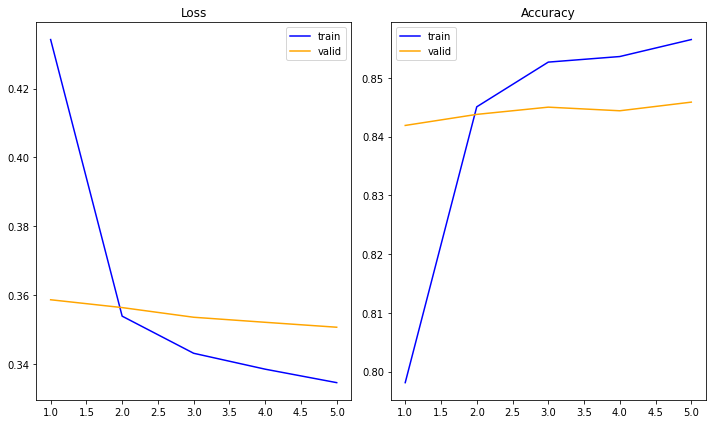

In [266]:
visulization("LSTM", lstm_history)

## 7) 학습된 Embedding 레이어 분석

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 회고
* 배운 점
  - 전체적인 처리 과정을 상세하게 학습할 수 있었다.
* 아쉬운 점
  - 하니씩 자세하게 보다보니 학습 시간내에는 프로젝트를 다 마무리 못해서 아쉬웠다. 
* 느낀 점
  - 분류 이외 여러 태스크들을 진행해봐야겠다.
* 어려웠던 점
  - 각 내용의 상세한 구현 및 구조를 깊게 파악하는게 쉽지 않은 것 같다.